In [1]:
import os

In [2]:
import geopandas as gpd
gpd.options.use_pygeos=True
import pandas as pd

In [3]:
import scipy.stats as stats  

In [4]:
os.getcwd()

'/home/lucas/repos/solar-pv-global-inventory/solarpv/analysis/generating_capacity'

In [5]:
root = os.path.abspath(os.path.join(os.getcwd(),'..','..','..'))

In [6]:
gdf = gpd.read_file(os.path.join(root,'data','SPV_newmw.gpkg'))

In [9]:
gdf['capacity_mw'].sum()/1000/107.4-1

2.5321368929205894

In [26]:
gdf[['capacity_mw','iso-3166-1']].groupby('iso-3166-1').sum().sort_values('capacity_mw',ascending=False).loc['JP','capacity_mw']/1000/6.0-1

1.7789591505097433

In [52]:
table_out = gdf[['capacity_mw','iso-3166-1']].groupby('iso-3166-1').sum().sort_values('capacity_mw',ascending=False).iloc[0:91]

In [56]:
table_out = table_out.loc[table_out.index!='',:]

In [57]:
table_out['N_installations'] = gdf[['unique_id','iso-3166-1']].groupby('iso-3166-1').size()

/home/lucas/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
table_out['mean_size'] = gdf[['capacity_mw','iso-3166-1']].groupby('iso-3166-1').mean()

/home/lucas/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
table_out['capacity_mw'] = table_out['capacity_mw'].apply(lambda el: f'{el:,.0f}')
table_out['N_installations'] = table_out['N_installations'].apply(lambda el: f'{el:,.0f}')
table_out['mean_size'] = table_out['mean_size'].apply(lambda el: f'{el:,.2f}')

/home/lucas/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/lucas/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/lucas/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [60]:
table_out

,capacity_mw,N_installations,mean_size
iso-3166-1,,,
CN,"167,698","18,449",9.09
US,"53,727","7,638",7.03
IN,"31,503","2,277",13.84
JP,"16,674","10,504",1.59
DE,"15,651","4,702",3.33
...,...,...,...
GH,23,3,7.74
BW,22,4,5.61
MG,21,1,21.35


In [61]:
table_out.to_csv(os.path.join(root,'data','summary_table.csv'))

In [21]:
gdf['capacity_mw'].sum()/1000- 107.4

271.95150229967135

In [7]:
bins = {
    0:{'min':10**2,'max':10**3,'recall':.18},
    1:{'min':10**3,'max':10**4,'recall':.25},
    2:{'min':10**4,'max':10**5,'recall':.71},
    3:{'min':10**5,'max':10**6,'recall':.82},
    4:{'min':10**6,'max':10**10,'recall':.88},
}

In [8]:
for kk,vv in bins.items():
    gdf.loc[(gdf['area']>=vv['min'])&(gdf['area']<vv['max']),'capacity_mw'] = gdf.loc[(gdf['area']>=vv['min'])&(gdf['area']<vv['max']),'capacity_mw'] /vv['recall']

In [9]:
gdf['capacity_mw'].sum()

494403.0784710179

In [41]:
#eia = pd.read_csv(os.path.join(root,'data','eia_powerstations','february_generator2020.csv'))
eia = pd.read_csv(os.path.join(root,'data','tabula-NREL.csv'))

In [42]:
eia.loc[~eia['Module efficiency'].isna(),'Module efficiency'] = eia.loc[~eia['Module efficiency'].isna(),'Module efficiency'].str.replace('%','').astype(float)/100

In [138]:
eff_alpha, eff_loc, eff_beta = stats.gamma.fit(eia.loc[~eia['Module efficiency'].isna(),'Module efficiency'].values.tolist())

In [154]:
ilr_alpha, ilr_loc, ilr_beta = stats.gamma.fit(eia.loc[(~eia['ILR'].isna()) & (eia['ILR']!=1) & (eia['ILR']<1.7),'ILR'].astype(float).values.tolist())

In [156]:
import matplotlib.pyplot as plt

In [169]:
from scipy.optimize import curve_fit

In [209]:
def fitgamma(xdata, alpha, loc, beta):
    data = sorted(stats.gamma.rvs(alpha, loc=loc, scale=beta, size=10000))
    mean, var, skew, kurt = stats.gamma.stats(alpha, loc=loc, scale=beta, moments='mvsk')
    return [data[2500],mean,data[5000],data[7500]]

In [212]:
curve_fit(fitgamma,5,[.44, .47, .51, .58], p0=[2,0,0.25])

(array([2.  , 0.  , 0.25]),
 array([[ 6.01146036e-13,  2.67472921e-13, -2.15498680e-15],
        [ 2.67472921e-13,  4.78974437e-13, -9.36265190e-14],
        [-2.15498680e-15, -9.36265190e-14,  4.17159345e-14]]))

In [189]:
stats.gamma.cdf(.75, 1, loc=0, scale=1)

0.5276334472589851

In [258]:
targets = {'25':.44,'50':.47,'mean':.51,'75':.58}
arr = np.zeros((50,50))
x_off, x_step = 0.01, 0.001
y_off, y_step = 18, 0.1
for x in [x for x in range(50)]:
    for y in [y for y in range(50)]:
        loc = x_off+x*x_step
        alpha = y_off+y*y_step
        beta =(.51-loc)/alpha
        mean, var, skew, kurt = stats.gamma.stats(alpha, loc=loc, scale=beta, moments='mvsk')
        data = sorted(stats.gamma.rvs(alpha, loc=loc, scale=beta, size=10000))
        res = {'25':data[2500],'50':data[5000],'mean':mean,'75':data[7500]}
        err = sum([(res[kk]-targets[kk])**2 for kk in targets.keys()])
        arr[x,y] = err
        #print (loc, alpha, err)

In [266]:
arr[16,21]

0.0008907956589904518

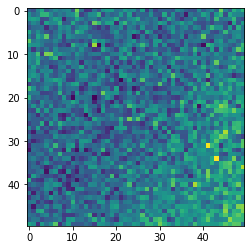

In [259]:
plt.imshow(arr)

In [271]:
np.where(arr<0.0009)

(array([16, 20]), array([21, 15]))

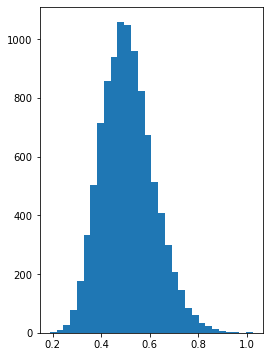

25 0.44 0.43298550795290325
50 0.47 0.5040432422727469
mean 0.51 0.51
75 0.58 0.5777619441614498


In [272]:
fig, ax = plt.subplots(1,1,figsize=(4,6))
alpha = 19.5 #20.1
loc = 0.030#26
beta =(.51-loc)/alpha
mean, var, skew, kurt = stats.gamma.stats(alpha, loc=loc, scale=beta, moments='mvsk')
data = sorted(stats.gamma.rvs(alpha, loc=loc, scale=beta, size=10000))
ax.hist(data, bins=30)
plt.show()
targets = {'25':.44,'50':.47,'mean':.51,'75':.58}
res = {'25':data[2500],'50':data[5000],'mean':mean,'75':data[7500]}
for kk in targets.keys():
    print (kk, targets[kk],res[kk])

In [64]:
import numpy as np

In [71]:
gdf['cap_test'] = gdf['area'] * gdf['GCR'] * gdf['gti'] * gdf['eff'] / gdf['pvout'] / gdf['ILR']

In [72]:
gdf['cap_test'].sum()

356009935.39428663

In [81]:
bins = {
    0:{'min':10**2,'max':10**3,'recall':.18},
    1:{'min':10**3,'max':10**4,'recall':.25},
    2:{'min':10**4,'max':10**5,'recall':.71},
    3:{'min':10**5,'max':10**6,'recall':.82},
    4:{'min':10**6,'max':10**10,'recall':.88},
}

In [288]:
print (f'gcr,{gcr_alpha:.2f}, {gcr_loc:.5f}, {gcr_beta:.7f}')
print (f'eff,{eff_alpha:.2f}, {eff_loc:.5f}, {eff_beta:.7f}')
print (f'ilr,{ilr_alpha:.2f}, {ilr_loc:.5f},{ilr_beta:.7f}')

gcr,19.50, 0.03000, 0.0246154
eff,1.82, 0.08744, 0.0323441
ilr,26.32, 0.68294,0.0183012


In [273]:
best_est = []
simple_est = []

gcr_alpha = 19.5 #20.1
gcr_loc = 0.030#26
gcr_beta =(.51-loc)/alpha

for _ in range(1000):
    gdf['GCR'] = stats.gamma.rvs(gcr_alpha, loc=gcr_loc, scale=gcr_beta, size=len(gdf))
    gdf['eff'] = stats.gamma.rvs(eff_alpha, loc=eff_loc, scale=eff_beta, size=len(gdf))
    gdf['ILR'] = stats.gamma.rvs(ilr_alpha, loc=ilr_loc, scale=ilr_beta, size=len(gdf))
    gdf['cap_test'] = gdf['area'] * gdf['GCR'] * gdf['gti'] * gdf['eff'] / gdf['pvout'] / gdf['ILR']
    mw_test = gdf['cap_test'].sum()/1000
    el = 0
    for kk, vv in bins.items():
        #print (vv,((gdf['area']>=vv['min'])&(gdf['area']<vv['max'])).sum())
        el += gdf.loc[((gdf['area']>=vv['min'])&(gdf['area']<vv['max'])),'cap_test'].sum()/vv['recall']
        
    best_est.append(el)
    simple_est.append(mw_test)

In [86]:
import matplotlib.pyplot as plt

In [274]:
np.quantile(np.array(sorted(best_est))/1000/1000,[0.025,0.975]), (np.array(sorted(best_est))/1000/1000).mean()

(array([491.73178332, 503.76027381]), 497.5955790225119)

In [276]:
491.73178332 - 497.5955790225119, 503.76027381 - 497.5955790225119

(-5.863795702511936, 6.164694787488088)

In [277]:
np.quantile(np.array(sorted(simple_est))/1000,[0.025,0.975]), (np.array(sorted(simple_est))/1000).mean()

(array([376.76603617, 387.15172976]), 381.80327804035784)

(array([  1.,   1.,   0.,   7.,  22.,  51.,  77., 117., 141., 139., 149.,
        114.,  72.,  58.,  29.,  13.,   5.,   1.,   0.,   3.]),
 array([4.86016144e+08, 4.87215253e+08, 4.88414362e+08, 4.89613471e+08,
        4.90812579e+08, 4.92011688e+08, 4.93210797e+08, 4.94409906e+08,
        4.95609015e+08, 4.96808123e+08, 4.98007232e+08, 4.99206341e+08,
        5.00405450e+08, 5.01604558e+08, 5.02803667e+08, 5.04002776e+08,
        5.05201885e+08, 5.06400994e+08, 5.07600102e+08, 5.08799211e+08,
        5.09998320e+08]),
 <BarContainer object of 20 artists>)

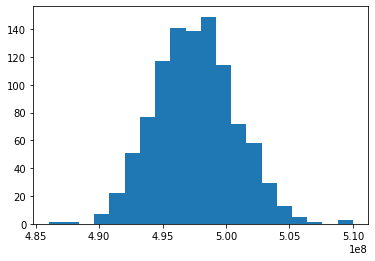

In [278]:
plt.hist(best_est, bins=20)

In [279]:
GCR_mean, var, skew, kurt = stats.gamma.stats(gcr_alpha, loc=gcr_loc, scale=gcr_beta, moments='mvsk')
eff_mean, var, skew, kurt = stats.gamma.stats(eff_alpha, loc=eff_loc, scale=eff_beta, moments='mvsk')
ilr_mean, var, skew, kurt = stats.gamma.stats(ilr_alpha, loc=ilr_loc, scale=ilr_beta, moments='mvsk')

In [280]:
gdf['GCR'] = GCR_mean
gdf['eff'] = eff_mean
gdf['ILR'] = ilr_mean
gdf['capacity_mw'] = gdf['area'] * gdf['GCR'] * gdf['gti'] * gdf['eff'] / gdf['pvout'] / gdf['ILR'] / 1000

In [282]:
gdf.to_file(os.path.join(root,'data','SPV_newmw.gpkg'),driver='GPKG')

In [281]:
gdf['capacity_mw'].sum()/1000

379.3515022996713

In [14]:
eia[eia['Technology']=='Solar Photovoltaic'].to_csv(os.path.join(root,'data','eia_powerstations','pv_only.csv'))

In [120]:
np.random.choice(10,5, replace=False)

array([9, 1, 0, 3, 7])

In [8]:
gdf.columns

Index(['unique_id', 'area', 'confidence', 'install_date', 'install_date_ints',
       'iso-3166-1', 'iso-3166-2', 'gti', 'pvout', 'capacity_mw', 'match_id',
       'WDPA_proximity', 'LC_CLC300_1992', 'LC_CLC300_1993', 'LC_CLC300_1994',
       'LC_CLC300_1995', 'LC_CLC300_1996', 'LC_CLC300_1997', 'LC_CLC300_1998',
       'LC_CLC300_1999', 'LC_CLC300_2000', 'LC_CLC300_2001', 'LC_CLC300_2002',
       'LC_CLC300_2003', 'LC_CLC300_2004', 'LC_CLC300_2005', 'LC_CLC300_2006',
       'LC_CLC300_2007', 'LC_CLC300_2008', 'LC_CLC300_2009', 'LC_CLC300_2010',
       'LC_CLC300_2011', 'LC_CLC300_2012', 'LC_CLC300_2013', 'LC_CLC300_2014',
       'LC_CLC300_2015', 'LC_CLC300_2016', 'LC_CLC300_2017', 'LC_CLC300_2018',
       'mean_ai', 'lc_mode', 'lc_arid', 'lc_vis', 'geometry'],
      dtype='object')